# Introduction
State notebook purpose here

### Imports
Import libraries and write settings here.

In [52]:
# Notebooks specific imports
from IPython import get_ipython

ipython = get_ipython()
# Expand notebook display

from IPython.display import display, HTML

display(HTML("<style>.container { width:80% !important; }</style>"))
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
# autoreload extension
if "autoreload" not in ipython.extension_manager.loaded:
    %load_ext autoreload
%autoreload 2
from tqdm.notebook import tqdm

# Basic useful imports
import re
import time
import yaml
from pprint import pprint
from pathlib import Path
import h5py
import warnings
from cycler import cycler

# Data manipulation
import numpy as np
from scipy.special import erf
from scipy.integrate import quad
import scipy.stats as stats
from scipy.signal import savgol_filter
from scipy.spatial import ConvexHull
from scipy.optimize import root_scalar

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D
from matplotlib.patches import (
    Circle,
    RegularPolygon,
    FancyArrowPatch,
    ArrowStyle,
    Rectangle,
)
from matplotlib.ticker import (
    MultipleLocator,
    FormatStrFormatter,
    AutoMinorLocator,
    NullFormatter,
)
import matplotlib.colors as mcolors

# Clustering stuff
from sklearn.cluster import MeanShift, estimate_bandwidth, DBSCAN, OPTICS
from itertools import cycle
# plt.cm.tab20.colors

# From alens_analysis.py
import alens_analysis as aa
import alens_analysis.chromatin as aac
import alens_analysis.chromatin.chrom_analysis as ca
import alens_analysis.chromatin.chrom_condensate_analysis as cca
import alens_analysis.chromatin.chrom_graph_funcs as cgf
from alens_analysis import cluster_analysis as cla

from alens_analysis.colormaps import register_cmaps

# Locations
ws_path = Path("/home/alamson/DATA/Chromatin/")
mnt_path = Path.home() / "projects/DATA/Chromatin/"
ceph_path = Path.home() / "ceph/DATA/Chromatin/"

In [2]:
# Consistent settings
ss_ind = 1
end_ind = None
start_bead = 0
end_bead = None
part_min = 40

### Style settings

In [3]:
graph_sty = {
    "axes.titlesize": 20,
    "axes.labelsize": 24,
    "lines.linewidth": 2,
    "lines.markersize": 2,
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "font.size": 20,
    "font.sans-serif": "Helvetica",
    "text.usetex": False,
    "mathtext.fontset": "cm",
}
plt.style.use(graph_sty)

colors = cycle(mcolors.XKCD_COLORS.keys())
# mcolors.__dict__
# colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")

register_cmaps()
# plt.rcParams['image.cmap'] = 'emct8'
# plt.rcParams['image.cmap'] = 'warm'
plt.rcParams["image.cmap"] = "YlOrRd"
# plt.rcParams['image.cmap'] = 'twilight'
# plt.rcParams['image.cmap'] = 'coolwarm'
# plt.rcParams['image.cmap'] = 'RdYlBu_r'

## Figure 2a (number of beads in condensates)

In [4]:
def plot_confidence_int(
    ax, time_arr, mean, std_dev, num_runs=12, color="b", ci=0.95, label="Mean"
):
    degrees_freedom = num_runs - 1
    confidence_interval = (
        stats.t.ppf((1 + ci) / 2.0, degrees_freedom) * std_dev / np.sqrt(num_runs)
    )

    _ = ax.plot(time_arr, mean, label=label, color=color)
    _ = ax.fill_between(
        time_arr,
        mean - confidence_interval,
        mean + confidence_interval,
        color=color,
        alpha=0.1,
    )

1201
1201
1201
1201
1201


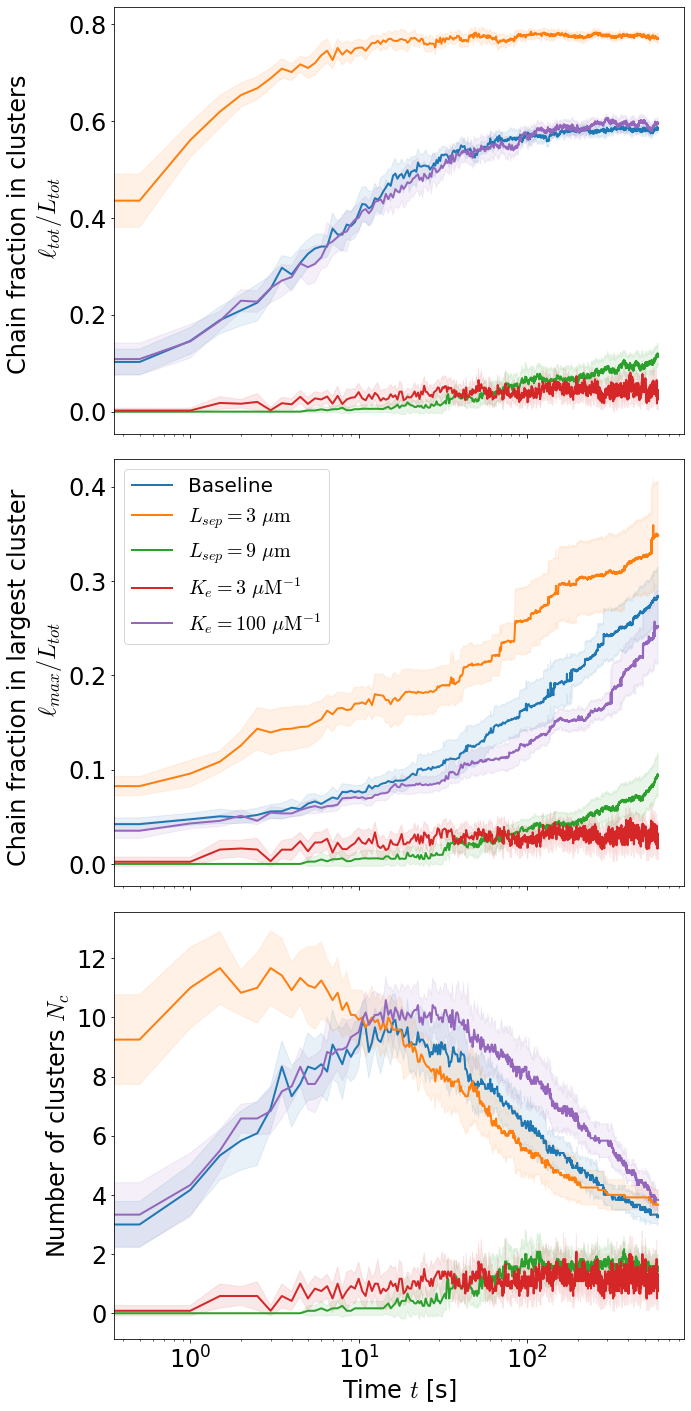

In [110]:
labels_to_graph_dict = {
    "Baseline": "Pin5.0um_Ke30/",
    r"$L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    r"$K_e = 3~\mu {\rm M}^{-1}$": "Pin5.0um_Ke3/",
    r"$K_e = 100~\mu {\rm M}^{-1}$": "Pin5.0um_Ke100",
}

fig, axarr = plt.subplots(3, 1, figsize=(10, 20), sharex=True)
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for (label, key), color in zip(labels_to_graph_dict.items(), plt.cm.tab10.colors):
        h5_data = h5d[key]

        num_runs = h5_data.attrs["num_runs"]
        mean = h5_data[:, 0]
        min_length = min(mean.size, time_arr.size)
        print(min_length)
        mean = h5_data[:min_length, 0]
        std_dev = h5_data[:min_length, 1]
        # num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(
            axarr[0],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            12,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 4]
        std_dev = h5_data[:min_length, 5]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[1],
            time_arr[:min_length],
            mean / 1600,
            std_dev / 1600,
            num_runs,
            color=color,
            label=label,
        )

        mean = h5_data[:min_length, 2]
        std_dev = h5_data[:min_length, 3]
        num_runs = h5_data.attrs["num_runs"]
        plot_confidence_int(
            axarr[2],
            time_arr[:min_length],
            mean,
            std_dev,
            num_runs,
            color=color,
            label=label,
        )

    _ = axarr[0].set_ylabel("Chain fraction in clusters \n $\ell_{tot} / L_{tot}$")
    _ = axarr[0].set_xscale("log")

    _ = axarr[1].set_ylabel(
        "Chain fraction in largest cluster \n $\ell_{max} / L_{tot}$"
    )
    _ = axarr[1].legend(loc="upper left", bbox_to_anchor=(0, 1.0))

    _ = axarr[2].set_ylabel("Number of clusters $N_c$")
    _ = axarr[2].set_xlabel("Time $t$ [s]")
    fig.tight_layout()

    fig.savefig("Figure2/fig2_time_plot.png", dpi=300, bbox_inches="tight")

    # _ = axarr.legend(loc='center left', bbox_to_anchor=(1.05, .5))

## Figure 2b (Condensate state diagram)

240
[ 316.0425573  1043.36470588]


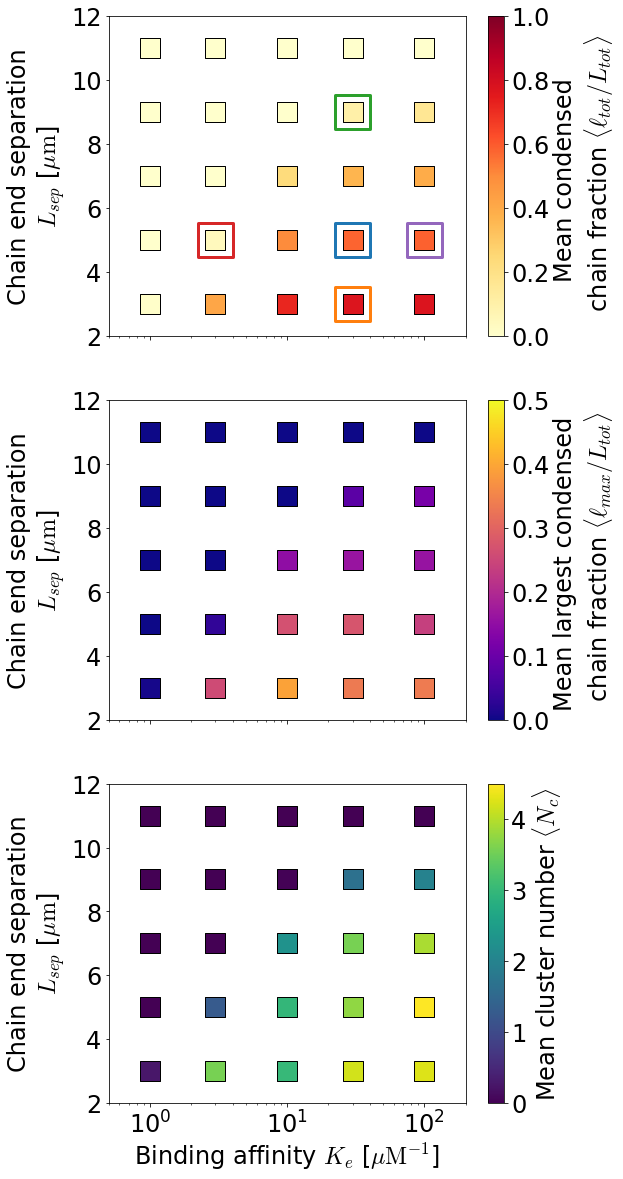

In [109]:
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 8))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[-time_arr.size // 5 :, 0].mean(),
                h5_data[-time_arr.size // 5 :, 1].mean(),
                h5_data[-time_arr.size // 5 :, 2].mean(),
                h5_data[-time_arr.size // 5 :, 3].mean(),
                h5_data[-time_arr.size // 5 :, 4].mean(),
                h5_data[-time_arr.size // 5 :, 5].mean(),
            ]
print(time_arr.size // 5)
fig, axarr = plt.subplots(3, 1, figsize=(8, 20), sharex=True, sharey=True)

# Define the color conditions
conditions = [
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 3.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 9.0) & (data_arr[:,1] == 30),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 3),
    (data_arr[:,0] == 5.0) & (data_arr[:,1] == 100),
]

# Define the color for each condition
colors = ['C0', 'C1', 'C2', 'C3', 'C4']

# Use np.select to assign colors to the conditions
color_array = np.select(conditions, colors, default= 'none')

_ = axarr[0].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    facecolors="none",
    # c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=1200,
    marker="s",
    edgecolors=color_array,
    linewidths=3,
)
## Condensed fraction graph
_ = axarr[0].set_xscale("log")
_ = axarr[0].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2] / 1600,
    vmin=0,
    vmax=1,
    cmap="YlOrRd",
    s=400,
    marker="s",
    edgecolors='k',
    linewidths=1,
)
cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1), cmap="YlOrRd"),
    ax=axarr[0],
    label="Mean condensed \n chain fraction" + r" $\langle \ell_{tot}/L_{tot} \rangle$",
)

## Max cluster fraction
msc = axarr[1].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 6] / 1600,
    cmap="plasma",
    vmin=0,
    vmax=0.5,
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=0.5), cmap="plasma"),
    ax=axarr[1],
    label="Mean largest condensed \n chain fraction"
    + r" $\langle \ell_{max}/L_{tot} \rangle$",
)

## Number of cluster graph

# # Define the number of color steps you want
# n_bins = 9  # for example

# # Create a colormap with the desired number of color steps
# cmap = plt.get_cmap("viridis", n_bins)

# # Create a norm with boundaries at the desired locations
# boundaries = np.linspace(0, int(np.max(data_arr[:, 4])) + 0.5, n_bins + 1)
# norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Create the scatter plot
# sc = axarr[2].scatter(data_arr[:, 1], data_arr[:, 0], c=data_arr[:, 4], cmap=cmap, norm=norm, s=400, marker='s', edgecolors='k', linewidths=1)
sc = axarr[2].scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 4],
    cmap="viridis",
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

# Create a colorbar
# cb2 = fig.colorbar(sc, ax=axarr[1], ticks=boundaries, label='Mean cluster number')
cb2 = fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin=0, vmax=int(np.max(data_arr[:, 4])) + 0.5),
        cmap="viridis",
    ),
    ax=axarr[2],
    label=r"Mean cluster number $\langle N_c \rangle$",
)
_ = axarr[0].set_xlim(0.5, 200)
_ = axarr[0].set_ylim(2, 12)

# Add boxes around points that are graphed above

from matplotlib.transforms import blended_transform_factory

# Create a blended transform
# transform = blended_transform_factory(axarr[0].transData, axarr[0].transAxes.inverted())
transform = axarr[0].transData
print(transform.transform((30, 5)))

# Use this transform to create the rectangles
# height, width = 500, 500
# height, width = .1, .1
# baseline_sqr = Rectangle((30, 5), width, height, edgecolor='C0', facecolor='none', linewidth=2)
# baseline_sqr = Rectangle((.4, .4), width, height, transform=axarr[0].transAxes, edgecolor='C0', facecolor='none', linewidth=2)
# Lsep3 = Rectangle((30, 3), width,height,  edgecolor='C1', facecolor='none', linewidth=2)
# Lsep9 = Rectangle((30, 9), width, height, edgecolor='C2', facecolor='none', linewidth=2)
# Ke3 = Rectangle((3, 5), width, height, edgecolor='C3', facecolor='none', linewidth=2)
# Ke100 = Rectangle((100, 5), width, height, edgecolor='C4', facecolor='none', linewidth=2)

# axarr[0].add_patch(baseline_sqr)
# axarr[0].add_patch(Lsep3)
# axarr[0].add_patch(Lsep9)
# axarr[0].add_patch(Ke3)
# axarr[0].add_patch(Ke100)


for ax in axarr:
    # _ = ax.set_xlabel(r"Binding affinity [$\mu {\rm M}^{-1}$]")
    _ = ax.set_ylabel(r"Chain end separation" + "\n" + r"$L_{sep}$ [$\mu {\rm m}$]")
_ = axarr[2].set_xlabel(r"Binding affinity $K_e$ [$\mu {\rm M}^{-1}$]")


fig.savefig("Figure2/fig2_pin_ke.png", dpi=600, bbox_inches="tight")

## Figure 2c (Comparison with experiments)

In [12]:
# Functions
def free_energy_droplet(Ld, mu, alpha, gamma):
    return -mu * alpha * Ld + gamma * 4.0 * np.pi * np.power(
        3.0 * alpha * Ld / (4 * np.pi), 2.0 / 3.0
    )


def free_energy_polymer(Ld, Ltot, Lsep, kappa):
    eps = Ltot - Ld
    return (
        0.25
        * kappa
        * ((eps / (1.0 - (Lsep / eps))) - Lsep + 2.0 * ((Lsep * Lsep) / eps) - eps)
    )


def tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return free_energy_droplet(Ld, mu, alpha, gamma) + free_energy_polymer(
        Ld, Ltot, Lsep, kappa
    )


def free_energy_deriv(Ld, Ltot, Lsep, mu, alpha, gamma, kappa):
    return -mu * alpha + (1.0 / 12.0) * (
        8.0 * np.power(6.0 * alpha, 2.0 / 3.0) * gamma * np.power(np.pi / Ld, 1.0 / 3.0)
        + 3.0
        * kappa
        * (Lsep**2)
        * (2.0 / np.power(Ld - Ltot, 2.0) + 1.0 / np.power(Lsep + Ld - Ltot, 2.0))
    )


def length_prob_unnorm(Ld, Ltot, Lsep, mu, alpha, gamma, kappa, beta=1.0 / 0.0041):
    return np.exp(-beta * tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa))
    # return tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)


def partition_function(Ltot, Lsep, mu, alpha, gamma, kappa, beta=1.0 / 0.0041):
    return quad(
        lambda Ld: np.exp(
            -beta * tot_free_energy(Ld, Ltot, Lsep, mu, alpha, gamma, kappa)
        ),
        0,
        Ltot - (Lsep * 1.001),
    )

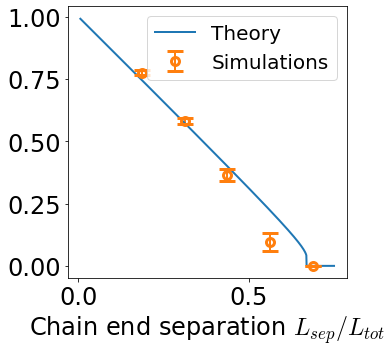

In [28]:
# Parameters (from Renger et al.)
# mu = 11. # Free energy per volume pN/um^2
# alpha = .05 # Condensate packing factor per length um^2
# gamma = .15 # Surface tension pN/um
# kappa = .0822 # Filament flexibility pN
# Ltot = 16.5 # Total length of the polymer um

mu = 4.1  # Free energy per volume pN/um^2
alpha = 0.05  # Condensate packing factor um^2
gamma = 0.15  # Surface tension pN/um
kappa = 0.0822  # Filament flexibility pN
Ltot = 16.0  # Total length of the polymer um

beta = 1.0 / 0.0041
fig, axarr = plt.subplots(1, 1, figsize=(5, 5))


# Get theoretical results
lsep_arr = np.linspace(0.1, 12, 1000)

ld_max_prob = np.zeros(lsep_arr.size)
for i, lsep in enumerate(lsep_arr):
    bound = 0.1
    while free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa) > 0:
        bound += 0.5
    if bound > Ltot - (lsep * 1.0000001):
        ld_max_prob[i] = 0.0
        continue
    # free_energy_deriv(bound, Ltot, lsep, mu, alpha, gamma, kappa)
    # free_energy_deriv(Ltot-(lsep*1.0000001), Ltot, lsep, mu, alpha, gamma, kappa)
    result = root_scalar(
        free_energy_deriv,
        method="brentq",
        bracket=[bound, Ltot - (lsep * 1.0000001)],
        args=(Ltot, lsep, mu, alpha, gamma, kappa),
    )
    ld_max_prob[i] = result.root
_ = axarr.plot(lsep_arr / Ltot, ld_max_prob / Ltot, label="Theory")
_ = axarr.set_xlabel(r"Chain end separation $L_{sep}/L_{tot}$")
# _ = axarr.set_ylabel(r"Total condensed length $\ell_{tot}/L_{tot}$")

with h5py.File("Figure2/fig2b_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]

    pin_dist_arr = []
    beads_num_arr = []
    beads_std_arr = []
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            Ke, pin_dist = h5_data.attrs["Ke"], h5_data.attrs["pin_dist"]
            if Ke == 30:
                pin_dist_arr += [pin_dist]
                beads_num_arr += [h5_data[time_arr.size // 2 :, 0].mean()]
                beads_std_arr += [h5_data[time_arr.size // 2 :, 1].mean()]

    _ = axarr.errorbar(
        np.array(pin_dist_arr) / 16.0,
        np.array(beads_num_arr) / 1600.0,
        yerr=np.array(beads_std_arr) / 1600.0,
        fmt="o",
        markeredgewidth=3,
        markersize=8,
        markerfacecolor="none",
        capsize=8,
        label="Simulations",
    )


_ = axarr.legend()
fig.savefig("Figure2/fig2_inset.png", dpi=300, bbox_inches="tight")

# Collect data

In [51]:
slice_path = (
    ceph_path
    / "DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations"
)

pin_ke_data_dict = {}


def parse_params(param_dir):
    data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
    with h5py.File(data_path, "r") as h5_data:
        run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
        prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

    return run_params["pinDist"], prot_params["proteins"][0]["Ke"][1]


for param_dir in slice_path.glob("*"):
    print(param_dir)
    try:
        pin_dist, Ke = parse_params(param_dir)
        if pin_dist not in pin_ke_data_dict:
            pin_ke_data_dict[pin_dist] = {}

        sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

        num_runs = len(sd_h5_file_lst)
        min_run_length = min(
            [len(h5py.File(h5p, "r")["time"]) for h5p in sd_h5_file_lst]
        )
        with h5py.File(sd_h5_file_lst[0], "r") as h5d:
            time_arr = h5d["time"][ss_ind:end_ind]
            nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_max_num_beads_arr = np.zeros((len(sd_h5_file_lst), min_run_length))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), min_run_length))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / "cluster_analysis.h5"
            with h5py.File(h5_clust_file, "r") as h5_data:
                cluster_grp = h5_data["clusters"]
                time_grp_list = sorted(
                    cluster_grp.values(), key=lambda x: x.attrs["time"]
                )
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]

            # assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                if c >= min_run_length:
                    break
                # Secondary thresholding
                clust_grp = [
                    clust for clust in clust_grp if len(clust.part_ids) > part_min
                ]

                num_beads = 0
                max_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)
                    max_beads = max(max_beads, len(clust.part_ids))

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads
                avg_max_num_beads_arr[ih, c] = max_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        max_num_bead_mean = avg_max_num_beads_arr.mean(axis=0)
        max_num_bead_std_dev = avg_max_num_beads_arr.std(axis=0)
        pin_ke_data_dict[pin_dist][Ke] = [
            num_bead_mean,
            num_bead_std_dev,
            num_clust_mean,
            num_clust_std_dev,
            max_num_bead_mean,
            max_num_bead_std_dev,
            num_runs,
        ]

    except:
        raise
        print("Error occured")

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin11.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke10_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke1_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/24-03-08_aLc1_slice5.5.13_line1600_Pin3-11um_2xKe3-300_ks100/simulations/Ke3_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/

In [53]:
# Store pin_ke_data_dict as an hdf5 file
with h5py.File("Figure2/fig2_pin_ke_data_dict.h5", "w") as h5d:
    _ = h5d.create_dataset("time", data=time_arr)
    for pin_dist, ke_data in pin_ke_data_dict.items():
        for ke, data in ke_data.items():
            dset = h5d.create_dataset(
                f"Pin{pin_dist:.1f}um_Ke{ke:.3g}", data=np.vstack(data[:-1]).T
            )
            dset.attrs["pin_dist"] = pin_dist
            dset.attrs["Ke"] = ke
            dset.attrs["num_runs"] = data[-1]

# Old

In [ ]:
slice_path = (
    ceph_path
    / "DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations"
)

pin_ke_data_dict = {}


def parse_params(param_dir):
    data_path = next(param_dir.glob("s*")) / "analysis/raw_data.h5"
    with h5py.File(data_path, "r") as h5_data:
        run_params = yaml.safe_load(h5_data.attrs["RunConfig"])
        prot_params = yaml.safe_load(h5_data.attrs["ProteinConfig"])

    return run_params["pinDist"], prot_params["proteins"][0]["Ke"][1]


for param_dir in slice_path.glob("*"):
    print(param_dir)
    try:
        pin_dist, Ke = parse_params(param_dir)
        if pin_dist not in pin_ke_data_dict:
            pin_ke_data_dict[pin_dist] = {}

        # pin_ke_data_dict[pin_dist][Ke]= [pin_dist, Ke]

        sd_h5_file_lst = [h5p for h5p in param_dir.glob("s*/analysis/raw_data.h5")]

        num_runs += [len(sd_h5_file_lst)]
        with h5py.File(sd_h5_file_lst[0], "r") as h5d:
            time_arr = h5d["time"][ss_ind:end_ind]
            nbeads = h5d["raw_data"]["sylinders"][start_bead:end_bead, 0, 0].shape[0]

        avg_num_clust_beads_arr = np.zeros((len(sd_h5_file_lst), time_arr.size))
        avg_num_clust_arr = np.zeros((len(sd_h5_file_lst), time_arr.size))

        for ih, h5d in enumerate(sd_h5_file_lst):
            h5_clust_file = h5d.parent / "cluster_analysis.h5"
            with h5py.File(h5_clust_file, "r") as h5_data:
                cluster_grp = h5_data["clusters"]
                time_grp_list = sorted(
                    cluster_grp.values(), key=lambda x: x.attrs["time"]
                )
                clusters = []
                for tg in time_grp_list:
                    clusters += [[cla.Cluster(h5_data=c) for c in tg.values()]]

            assert len(clusters) == time_arr.size

            for c, clust_grp in enumerate(clusters):
                # Secondary thresholding
                clust_grp = [
                    clust for clust in clust_grp if len(clust.part_ids) > part_min
                ]

                num_beads = 0
                for i, clust in enumerate(clust_grp):
                    num_beads += len(clust.part_ids)

                avg_num_clust_arr[ih, c] = len(clust_grp)
                avg_num_clust_beads_arr[ih, c] += num_beads

        num_bead_mean = avg_num_clust_beads_arr.mean(axis=0)
        num_bead_std_dev = avg_num_clust_beads_arr.std(axis=0)
        num_clust_mean = avg_num_clust_arr.mean(axis=0)
        num_clust_std_dev = avg_num_clust_arr.std(axis=0)
        pin_ke_data_dict[pin_dist][Ke] = [
            num_bead_mean,
            num_bead_std_dev,
            num_clust_mean,
            num_clust_std_dev,
            num_runs,
        ]

    except:
        print("Error occured")
        pass

/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke300_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke10_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin9.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke3_Pin5.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke30_Pin7.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynCondPaper/23-10-20_aLc1_slice4.5.13_line1600_Pin3-9um_2xKe3-300_ks100/simulations/Ke300_Pin3.0um
/mnt/home/alamson/ceph/DATA/Chromatin/DynC

In [ ]:
# Store pin_ke_data_dict as an hdf5 file
with h5py.File("Figure2/fig2b_pin_ke_data_dict.h5", "w") as h5d:
    _ = h5d.create_dataset("time", data=time_arr)
    for pin_dist, ke_data in pin_ke_data_dict.items():
        for ke, data in ke_data.items():
            dset = h5d.create_dataset(
                f"Pin{pin_dist:.1f}um_Ke{ke:.3g}", data=np.vstack(data[:-1]).T
            )
            dset.attrs["pin_dist"] = pin_dist
            dset.attrs["Ke"] = ke
            dset.attrs["num_runs"] = data[-1]

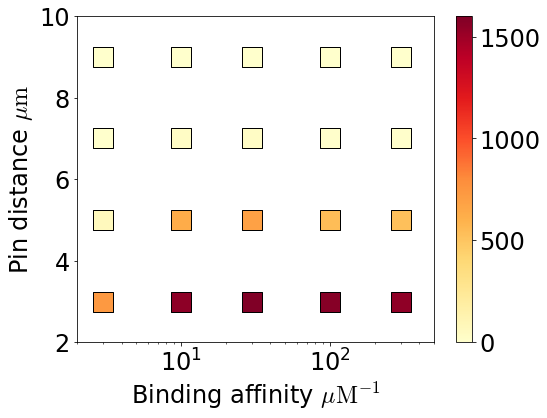

In [ ]:
with h5py.File("Figure2/fig2b_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[time_arr.size // 2 :, 0].mean(),
                h5_data[time_arr.size // 2 :, 1].mean(),
            ]

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale("log")
_ = axarr.scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2],
    cmap="YlOrRd",
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

cb1 = fig.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=1600), cmap="YlOrRd"),
    ax=axarr,
)
_ = axarr.set_xlim(2, 500)
_ = axarr.set_ylim(2, 10)
_ = axarr.set_ylabel(r"Pin distance $\mu {\rm m}$")
_ = axarr.set_xlabel(r"Binding affinity $\mu {\rm M}^{-1}$")

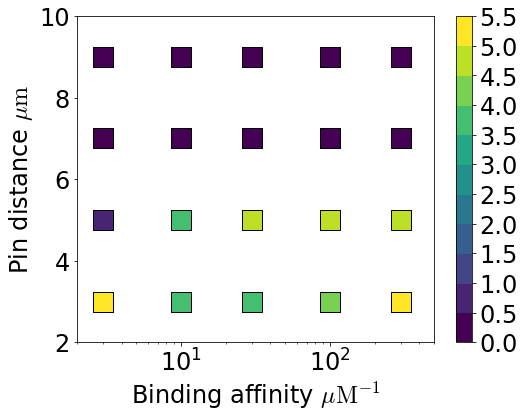

In [ ]:
with h5py.File("Figure2/fig2b_pin_ke_data_dict.h5", "r") as h5d:
    data_arr = np.zeros((len(h5d.keys()), 4))
    labels = []
    time_arr = h5d["time"][...]
    for i, label in enumerate(h5d.keys()):
        if label != "time":
            h5_data = h5d[label]
            data_arr[i, ...] = [
                h5_data.attrs["pin_dist"],
                h5_data.attrs["Ke"],
                h5_data[time_arr.size // 2 :, 2].mean(),
                h5_data[time_arr.size // 2 :, 3].mean(),
            ]


fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
_ = axarr.set_xscale("log")

# Define the number of color steps you want
n_bins = 11  # for example

# Create a colormap with the desired number of color steps
cmap = plt.get_cmap("viridis", n_bins)

# Create a norm with boundaries at the desired locations
boundaries = np.linspace(0, int(np.max(data_arr[:, 2])) + 0.5, n_bins + 1)
norm = mpl.colors.BoundaryNorm(boundaries, cmap.N)

# Create the scatter plot
sc = axarr.scatter(
    data_arr[:, 1],
    data_arr[:, 0],
    c=data_arr[:, 2],
    cmap=cmap,
    norm=norm,
    s=400,
    marker="s",
    edgecolors="k",
    linewidths=1,
)

# Create a colorbar
cb1 = fig.colorbar(sc, ax=axarr, ticks=boundaries)

_ = axarr.set_xlim(2, 500)
_ = axarr.set_ylim(2, 10)
_ = axarr.set_ylabel(r"Pin distance $\mu {\rm m}$")
_ = axarr.set_xlabel(r"Binding affinity $\mu {\rm M}^{-1}$")

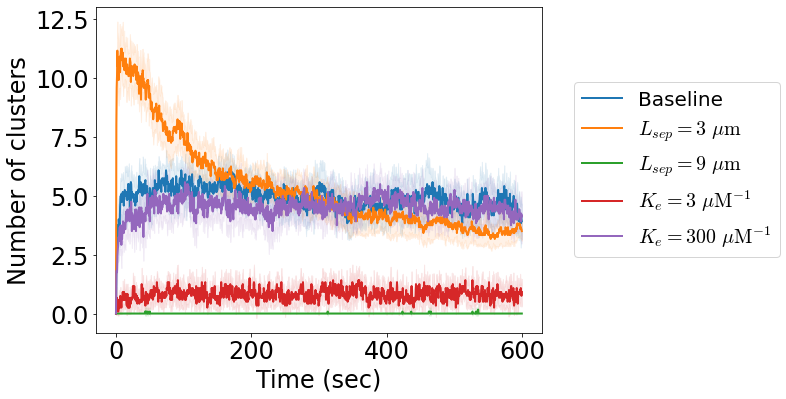

In [ ]:
# data_path_dict = {'Baseline': slice_path / "Ke30_Pin5.0um/",
#                   r'$L_{sep} = 3~\mu {\rm m}$' :slice_path / "Ke30_Pin3.0um/",
#                   r'$L_{sep} = 9~\mu {\rm m}$' : slice_path / "Ke30_Pin9.0um/",
#                   r'$K_e = 3~\mu {\rm M}^{-1}$' : slice_path / "Ke3_Pin5.0um/",
#                   r'$K_e = 300~\mu {\rm M}^{-1}$' : slice_path / "Ke300_Pin5.0um/",
#                   }

labels_to_graph_dict = {
    "Baseline": "Pin5.0um_Ke30/",
    r"$L_{sep} = 3~\mu {\rm m}$": "Pin3.0um_Ke30",
    r"$L_{sep} = 9~\mu {\rm m}$": "Pin9.0um_Ke30",
    r"$K_e = 3~\mu {\rm M}^{-1}$": "Pin5.0um_Ke3/",
    r"$K_e = 300~\mu {\rm M}^{-1}$": "Pin5.0um_Ke300",
}

fig, axarr = plt.subplots(1, 1, figsize=(8, 6))
tableau10_cycler = iter(cycler(color=plt.cm.tab10.colors))
with h5py.File("Figure2/fig2b_pin_ke_data_dict.h5", "r") as h5d:
    time_arr = h5d["time"][...]
    for label, key in labels_to_graph_dict.items():
        h5_data = h5d[key]
        mean = h5_data[:, 2]
        std_dev = h5_data[:, 3]
        # num_runs = h5_data.attrs['num_runs']
        plot_confidence_int(
            axarr,
            time_arr,
            mean,
            std_dev,
            12,
            color=next(tableau10_cycler)["color"],
            label=label,
        )

    _ = axarr.set_ylabel("Number of clusters")
    _ = axarr.set_xlabel("Time (sec)")
    _ = axarr.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))